In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage.io import imread, imshow
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [3]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=5 #Number of classes for segmentation

#Capture training image info as a list


In [22]:
train_images = []
num_images = 1000
image_names = glob.glob("OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image/*.png")
print(image_names)
image_names.sort()
print(image_names)
image_names_subset = image_names[0:num_images]
images = [cv2.resize(imread(img,0), dsize=(256, 256), interpolation=cv2.INTER_LINEAR) for img in image_names_subset]
images=np.delete(images,153,0)
train_images = np.array(images)

['OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_0.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_1.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_10.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_100.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_101.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_102.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_103.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_104.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\\ori_image_105.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/

In [386]:
print(image_names[195])


OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image\ori_image_95.png


In [25]:
mask_names = glob.glob("OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label/*.png")
train_masks=[]
mask_names.sort()
print(mask_names)
mask_names_subset = mask_names[0:num_images]
for mask in mask_names_subset:
  mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
  train_masks.append(mask)
train_masks = np.array(train_masks)
train_masks=np.delete(train_masks,153,0)

['OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_0.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_1.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_10.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_100.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_101.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_102.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_103.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_104.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label\\ori_label_105.png', 'OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/

In [26]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\ocbie\anaconda3\envs\tensorflow-env\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4], dtype=int64)

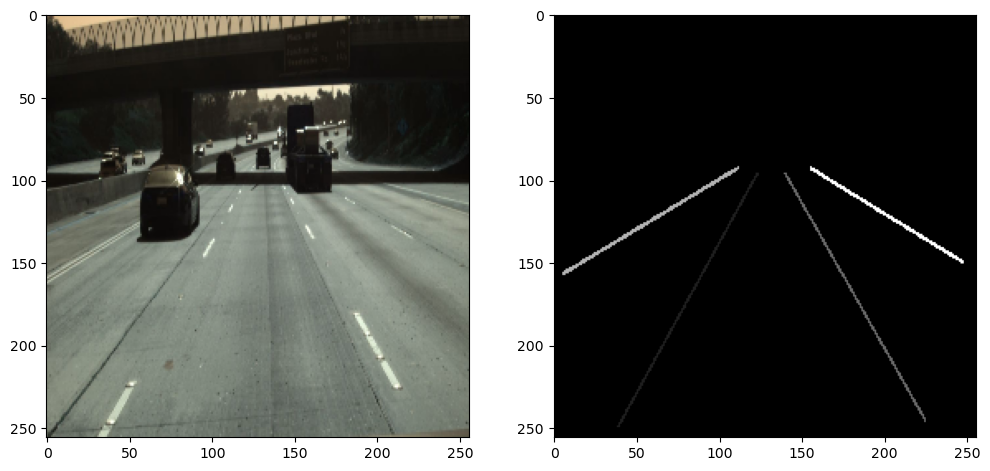

In [27]:
import random
# Visualize random image and label
image_number = random.randint(0, len(train_images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number])
plt.subplot(122)
plt.imshow(train_masks[image_number], cmap='gray')
plt.show()

In [28]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


In [29]:
print(train_images.shape)
print(train_masks_input.shape)

(199, 256, 256, 3)
(199, 256, 256, 1)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)
print("Class values in the dataset are ... ", np.unique(Y_train))

Class values in the dataset are ...  [0 1 2 3 4]


In [31]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(Y_train, num_classes=n_classes)
print(train_masks_cat.shape)
test_masks_cat = to_categorical(Y_test, num_classes=n_classes)
print(test_masks_cat.shape)

(159, 256, 256, 5)
(40, 256, 256, 5)


In [32]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [33]:
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

256
256
3


In [34]:
def unet(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    #Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [61]:
model = unet(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
_______________________________________________________________________________________

In [63]:
results = model.fit(X_train, train_masks_cat, validation_split=0.2, batch_size=4, epochs=50, callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')])


Epoch 1/50
32/32 [==============================] - 29s 915ms/step - loss: 0.2813 - accuracy: 0.9817 - val_loss: 0.2604 - val_accuracy: 0.9829
Epoch 2/50
32/32 [==============================] - 28s 889ms/step - loss: 0.1879 - accuracy: 0.9826 - val_loss: 0.1211 - val_accuracy: 0.9829
Epoch 3/50
32/32 [==============================] - 28s 889ms/step - loss: 0.1139 - accuracy: 0.9826 - val_loss: 0.1030 - val_accuracy: 0.9829
Epoch 4/50
32/32 [==============================] - 29s 894ms/step - loss: 0.1048 - accuracy: 0.9826 - val_loss: 0.0983 - val_accuracy: 0.9829
Epoch 5/50
32/32 [==============================] - 29s 901ms/step - loss: 0.1017 - accuracy: 0.9826 - val_loss: 0.0952 - val_accuracy: 0.9829
Epoch 6/50
32/32 [==============================] - 29s 906ms/step - loss: 0.0954 - accuracy: 0.9826 - val_loss: 0.0891 - val_accuracy: 0.9829
Epoch 7/50
32/32 [==============================] - 29s 909ms/step - loss: 0.0907 - accuracy: 0.9826 - val_loss: 0.0934 - val_accuracy: 0.9829

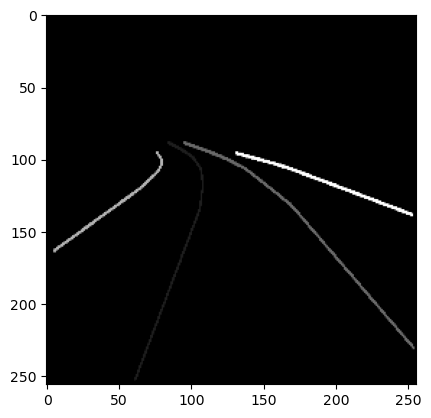

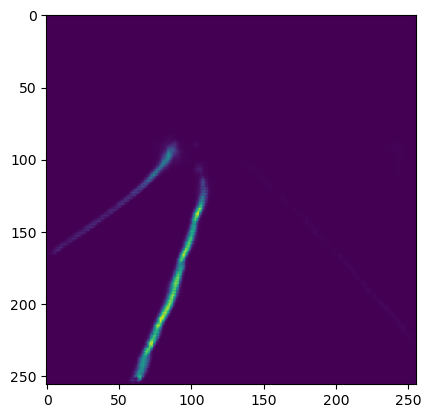

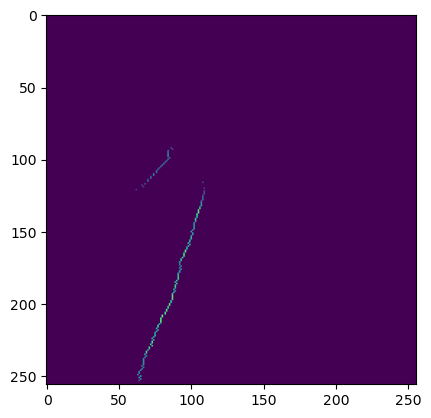

[ -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  86.  87.  84.  84.  84.  84.
  84.  85.  84.  83.  82.  81.  80.  79.  78.  77.  76.  76.  74.  74.
  72.  72.  70.  70. 108.  68.  66.  67. 109.  62. 109. 109. 109. 108.
 108. 108. 108. 107. 107. 107. 107. 106. 106. 105. 105. 105. 104. 104.
 104. 103. 103. 103. 102. 102. 102. 102. 102. 101. 100. 101. 101. 100.
 100. 100.  99.  99.  98.  99.  98.  97.  97.  96.  96.  95.  95.  95.
  94.  93.  93.  92.  92.  92.  93.  92.  93.  92.  92.  91.  91.  91.
  91.  91.  90.  89.  90.  89.  89.  89.  88.  89.  88.  87.  87.  87.
  87. 

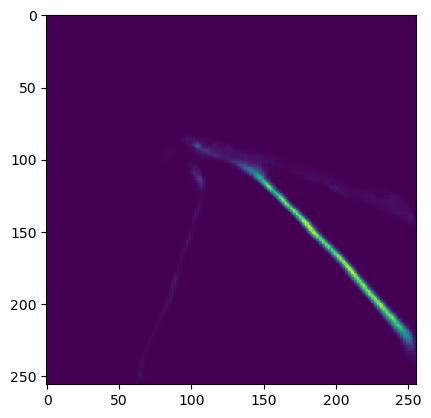

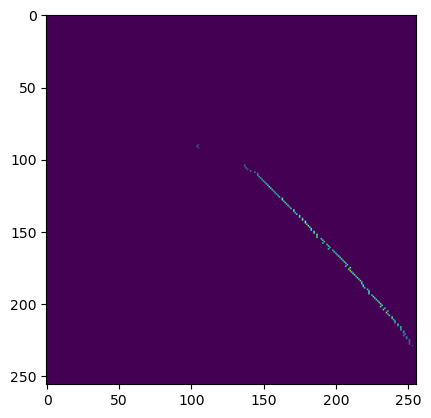

[ -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2. 105. 104. 105.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2. 137. 137. 138. 139. 141. 144. 146. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 163. 163. 164. 165. 166. 167. 168. 169. 171. 171. 172. 173. 175.
 175. 177. 177. 179. 179. 180. 181. 182. 183. 183. 185. 185. 187. 187.
 187. 190. 191. 192. 191. 194. 195. 196. 195. 198. 199. 200. 201. 202.
 203. 204. 205. 206. 207. 208. 207. 210. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218. 218. 219. 219. 220. 222. 223. 223. 223. 225. 226.
 227. 

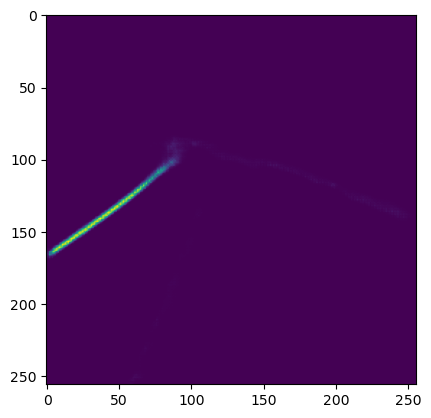

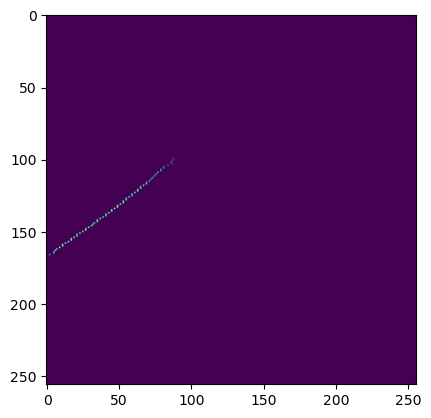

[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. 87. 88. 87. 86. 87. 84. 81. 81. 79.
 79. 77. 76. 75. 74. 73. 72. 71. 69. 69. 67. 65. 65. 63. 63. 61. 59. 59.
 57. 55. 55. 53. 53. 51. 49. 49. 47. 45. 45. 43. 41. 41. 39. 37. 35. 35.
 33. 32. 31. 29. 27. 27. 25. 23. 21. 21. 19. 17. 17. 15. 13. 11. 11.  9.
  7.  6.  5.  5.  2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2

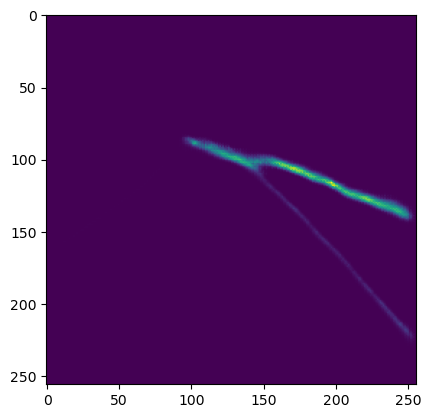

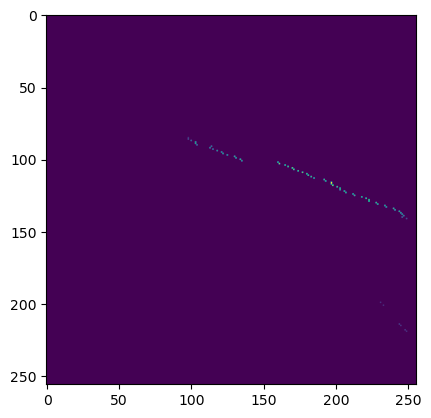

[ -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  98.  98. 100. 103. 103. 104. 114. 113. 115. 118. 121. 122. 125.
 130. 131. 134. 135. 160. 161. 165. 167. 170. 171. 174. 177. 180. 181.
 183. 185. 192. 193. 197. 197. 198. 201. 203. 203. 206. 207. 212. 213.
 218. 221. 223. 223. 228. 229. 234. 235. 240. 241. 244. 245. 246. 247.
 246. 249.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2. 

In [394]:
import random
i=67
test_img = cv2.resize(imread("OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original image/ori_image_95.png",0), dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
img = test_img.reshape(1,256,256,3)
ground_truth=cv2.resize(imread("OneDrive - University of Nebraska-Lincoln/MLFAO/multiclass predict/Original label/ori_label_95.png",0), dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
prediction = (model.predict(img))
prediction =np.squeeze(prediction)
plt.imshow(ground_truth)
plt.show()
for j in range(1,5):
    predim=np.zeros([256,256])
    x_coord=np.array([])
    for i in range(0,256):
        row=prediction[i,:,j]
        maxin=np.squeeze(np.where(row == np.amax(row)))
        if maxin.size==1 and row[maxin]>.1:
            predim[i,maxin]=row[maxin]
            x_coord=np.append(x_coord,maxin)
        else:
            x_coord=np.append(x_coord,-2)
    plt.imshow(prediction[:,:,j])
    plt.show()
    plt.imshow(predim)
    plt.show()
    print(x_coord)

In [347]:
def form_group(x_coord,y_pos,tol_dis,tol_convex):
    group=np.array([y_pos])
    current_y=y_pos+1
    while y_pos<255 and x_coord[y_current]=-2:
        y_current=y_current+1
    if group.size>2:
        slope_1=(x_coord[
        if ((x_coord[group[-1]]-x_coord[y_current])^2+(y_current-group[-1])^2<tol_dis) and (abs())

(1531,)

In [355]:
def far_sharp([y1,x1],[y2,x2],tol_dis,tol_invtan,skip_convex=false):
    m1=(y1-y2)/(x1-x2)
    distance=(y1-y2)^2+(x1-x2)^2
    if not skip_convex:
        m2=(y3-y2)/(x3-x2)
        invtan=-sgn(m2-m1)(m2-m1)/(1+m1*m2)
        if distance>tol_dis and 0<invtan<tol_invtan:
            return false
    else if distance>tol:
        return false
    else:
        return true
for j in range(1,5):
    group1=np.array([])
    group2=np.array([])
    group1add=true
    group2add=true
    for y_coord in range(0,256):
        row=prediction[y_coord,:,j]
        prob=np.amax(row)
        if prob>0.1:
            x_coord=np.squeeze(np.where(row == prob))
        else:
            continue
        if group1add and (group1.size==0 or (group1.size==1 and far_sharp(group1,))):
                group1=np.append([group1,[y_coord,x_coord]])
        
            

TypeError: len() of unsized object

In [390]:
np.array([240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710])/720*256

array([ 85.33333333,  88.88888889,  92.44444444,  96.        ,
        99.55555556, 103.11111111, 106.66666667, 110.22222222,
       113.77777778, 117.33333333, 120.88888889, 124.44444444,
       128.        , 131.55555556, 135.11111111, 138.66666667,
       142.22222222, 145.77777778, 149.33333333, 152.88888889,
       156.44444444, 160.        , 163.55555556, 167.11111111,
       170.66666667, 174.22222222, 177.77777778, 181.33333333,
       184.88888889, 188.44444444, 192.        , 195.55555556,
       199.11111111, 202.66666667, 206.22222222, 209.77777778,
       213.33333333, 216.88888889, 220.44444444, 224.        ,
       227.55555556, 231.11111111, 234.66666667, 238.22222222,
       241.77777778, 245.33333333, 248.88888889, 252.44444444])

In [408]:
mask_names[600]

IndexError: list index out of range